In [1]:
import pandas

In [2]:
df = pandas.read_csv("data/punching.tsv", names= [
    "right_bicep",
    "right_tricep",
    "left_bicep",
    "left_tricep",
    "right_thigh",
    "right_hamstring",
    "left_thigh",
    "left_hamstring"
], sep="\t")

In [3]:
df.head()

,right_bicep,right_tricep,left_bicep,left_tricep,right_thigh,right_hamstring,left_thigh,left_hamstring
0,139,-310,-4000,-114,1824,-1171,-4000,1533
1,798,-203,-4000,-318,3013,-1010,-4000,1597
2,1616,-78,-4000,-514,2813,-945,-4000,1598
3,1832,-66,-3935,-695,253,-912,-4000,1598
4,3514,-116,-2737,-724,-215,-875,-4000,1598


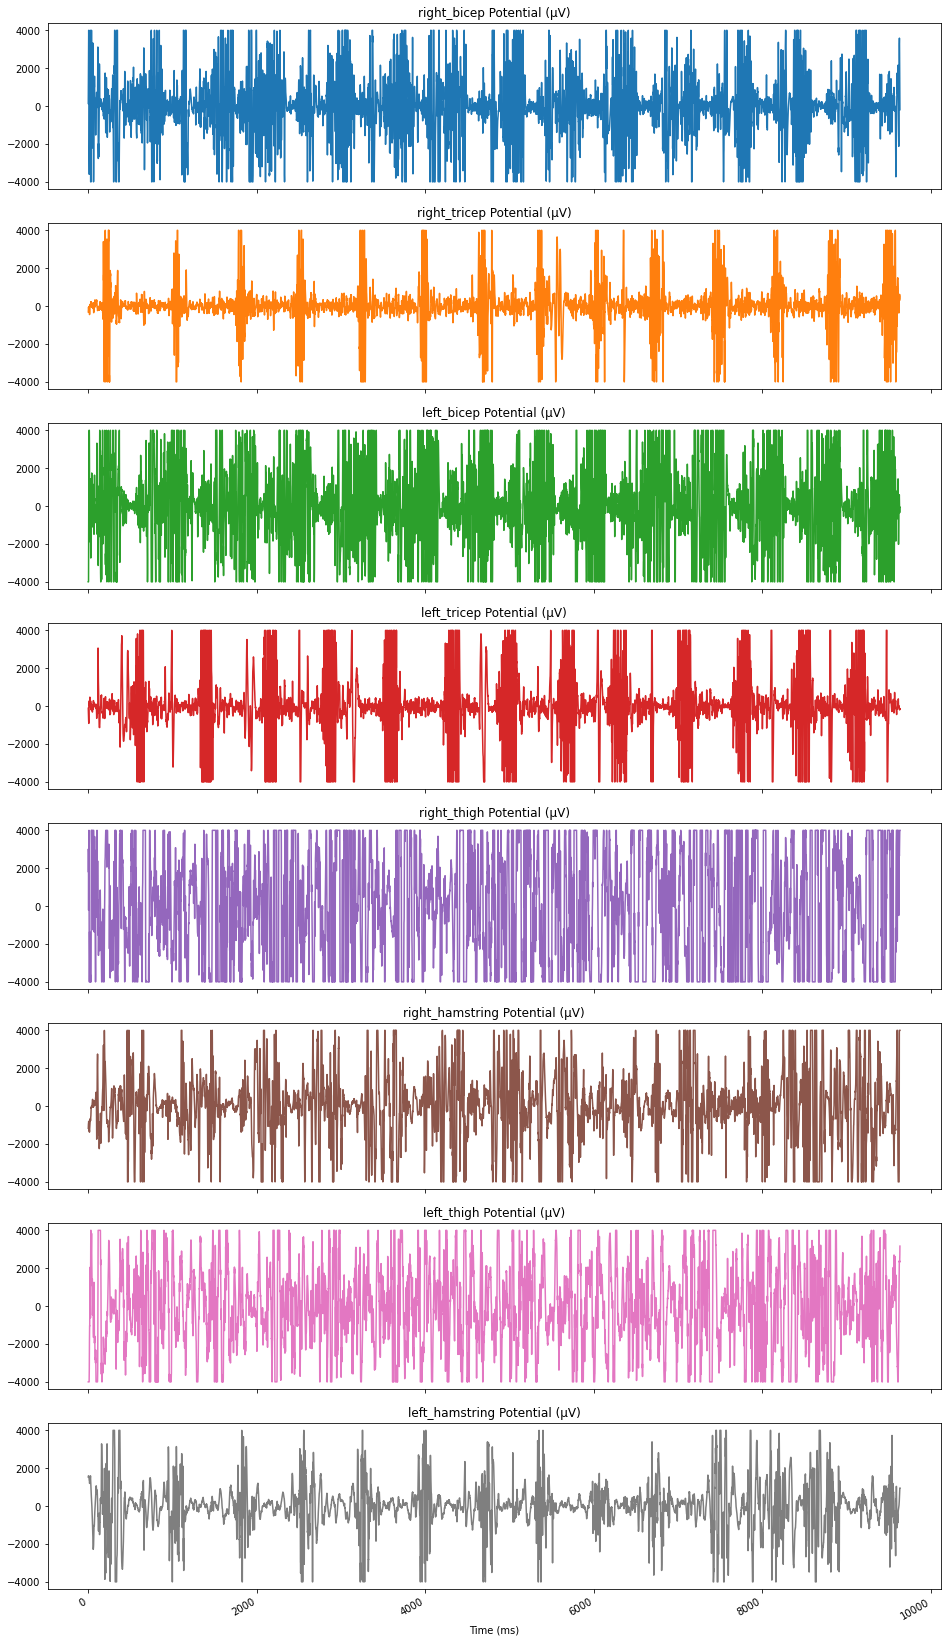

In [4]:
df.index.name = "Time (ms)"
titles = [f"{col} Potential (µV)" for col in df.columns]
df.plot(subplots=True, sharex=True, title=titles, legend=False, layout=(8, 1), figsize=(16,32));

In [5]:
from skmultiflow.drift_detection import ADWIN

all_drifts = {}
for column in df.columns:
    delta = 1.0
    detector = ADWIN(delta)

    drifts = []
    counter = 0
    for t, potential in enumerate(df[column].values):
        detector.add_element(potential)
        if detector.detected_change():
            drifts.append(potential)
            counter += 1
        else:
            drifts.append(None)
            if not t % 50:
                counter = 0
        if counter >= 2:
            delta *= 0.1
            detector.delta = delta  # each column will need adaptative delta
            counter = 0
    print(delta)
    all_drifts[column] = drifts
    detector.reset()

1.0
0.1
0.1
0.0010000000000000002
0.0010000000000000002
0.00010000000000000003
0.0010000000000000002
0.0010000000000000002


In [6]:
for column in all_drifts:
    print(column, sum([1 for el in all_drifts[column] if el is not None]), len(all_drifts[column]))

right_bicep 7 9637
right_tricep 9 9637
left_bicep 10 9637
left_tricep 12 9637
right_thigh 26 9637
right_hamstring 12 9637
left_thigh 27 9637
left_hamstring 21 9637


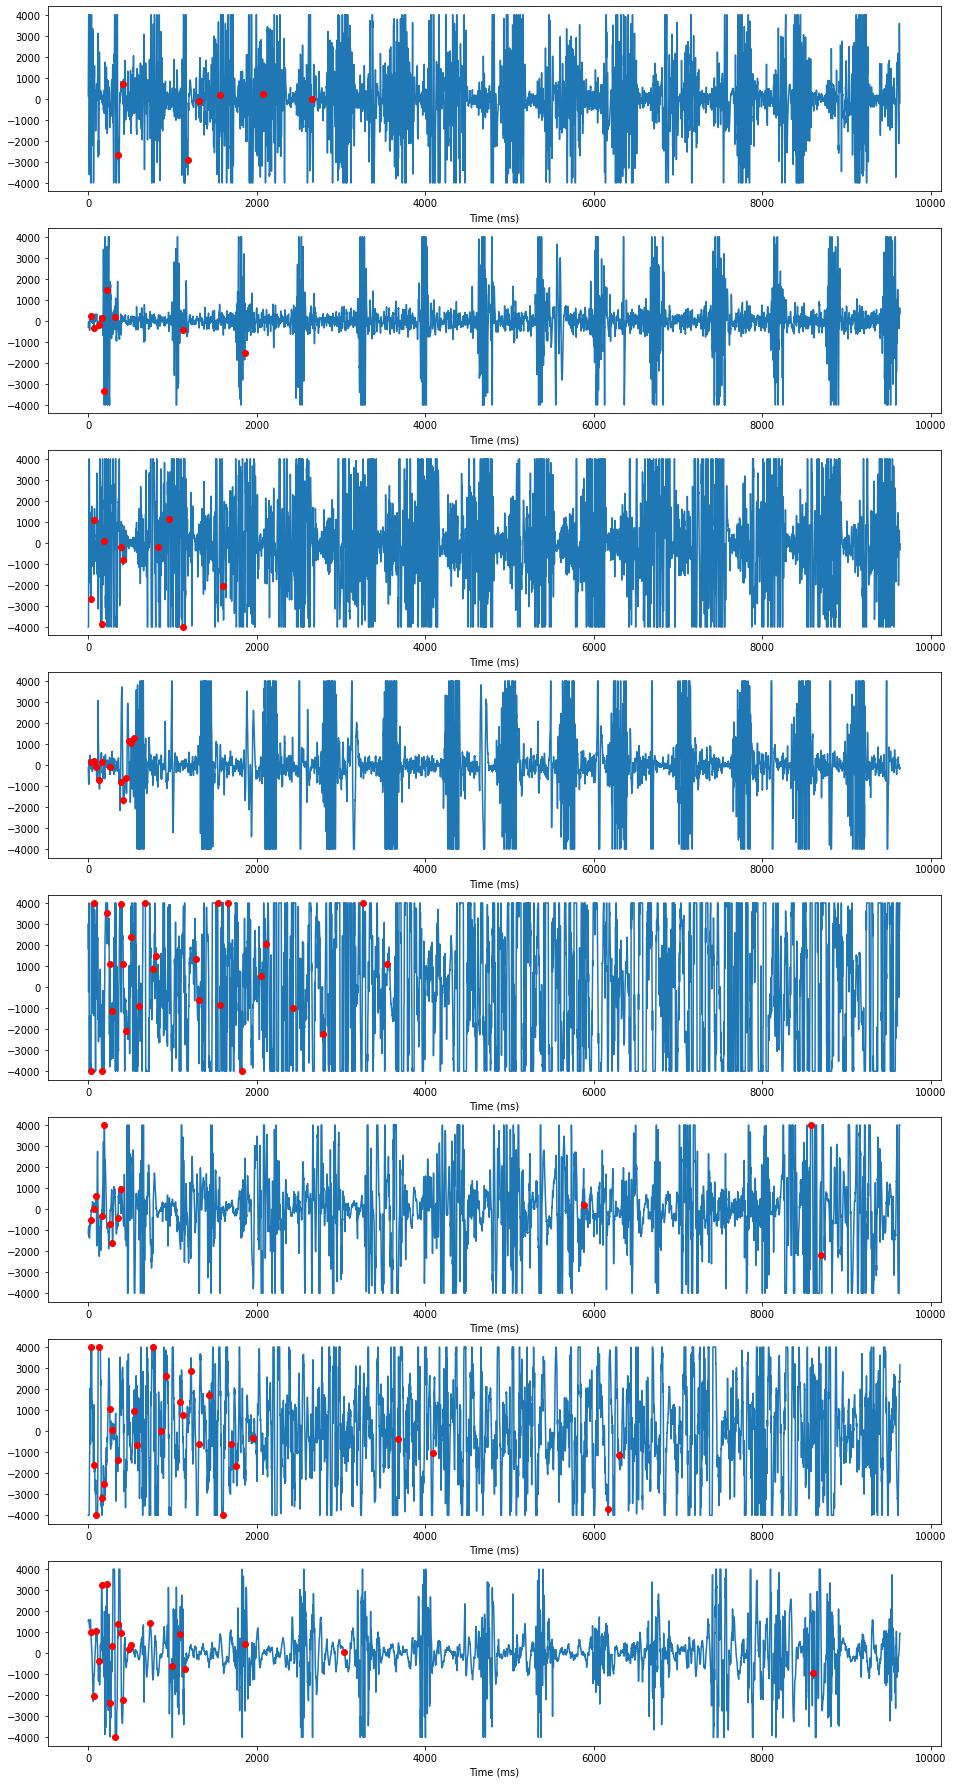

In [7]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(8, 1, figsize=(16, 32));

for ax, column in enumerate(df.columns):
    drift = all_drifts[column]
    df[column].plot(ax=axes[ax])
    axes[ax].plot(range(len(drift)), drift, "ro")